In [3]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from PIL import Image
from sklearn.model_selection import train_test_split

# ========== Device Setup ==========
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ========== Load the Dataset ==========
# Load all three arrays
images_np = np.load("../output/extra_large_images.npy")
angles_np = np.load("../output/extra_large_angles.npy")
signals_np = np.load("../output/extra_large_turn_signals.npy")

print(images_np.shape)     # Expected: (N, 160, 120, 3) or similar
print(signals_np.shape)    # Expected: (N,)
print(angles_np.shape)     # Expected: (N,)


Using device: cuda
(8998, 120, 160, 4)
(8998,)
(8998,)


In [4]:
# ========== Dataset Class ==========
class CarlaDataset(Dataset):
    def __init__(self, images_np, signals_np, angles_np):
        # Drop alpha channel (RGBA ➝ RGB)
        self.images = images_np[..., :3].astype(np.uint8)
        self.signals = signals_np
        self.angles = angles_np

        self.transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
        ])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.transform(self.images[idx])
        signal = torch.tensor([self.signals[idx]], dtype=torch.float32)
        angle = torch.tensor([self.angles[idx]], dtype=torch.float32)
        return img, signal, angle

In [5]:
# ========== Train/Validation Split ==========
train_imgs, val_imgs, train_signals, val_signals, train_angles, val_angles = train_test_split(
    images_np, signals_np, angles_np, test_size=0.2, random_state=42
)

train_dataset = CarlaDataset(train_imgs, train_signals, train_angles)
val_dataset   = CarlaDataset(val_imgs, val_signals, val_angles)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [6]:
# ========== Model Definition ==========
class DrivingModel(nn.Module):
    def __init__(self):
        super().__init__()
        cnn = models.resnet18(pretrained=True)
        cnn.fc = nn.Identity()  # remove classifier head
        self.cnn = cnn

        self.fc = nn.Sequential(
            nn.Linear(512 + 1, 128),
            nn.ReLU(),
            nn.Linear(128, 1)  # Steering angle output
        )

    def forward(self, img, signal):
        features = self.cnn(img)                      # (B, 512)
        x = torch.cat((features, signal), dim=1)      # (B, 513)
        return self.fc(x)

model = DrivingModel().to(device)

c:\Users\deyru\anaconda3\envs\ACS\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\deyru\anaconda3\envs\ACS\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [7]:
# ========== Loss and Optimizer ==========
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [8]:
# ========== Training Loop ==========
train_losses = []
val_losses = []

num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0

    for img, signal, angle in train_loader:
        img = img.to(device)
        signal = signal.to(device)
        angle = angle.to(device)

        output = model(img, signal)
        loss = criterion(output, angle)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * img.size(0)

    avg_train_loss = train_loss / len(train_loader.dataset)

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for img, signal, angle in val_loader:
            img = img.to(device)
            signal = signal.to(device)
            angle = angle.to(device)

            output = model(img, signal)
            loss = criterion(output, angle)
            val_loss += loss.item() * img.size(0)

    avg_val_loss = val_loss / len(val_loader.dataset)
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

Epoch 1/10 | Train Loss: 0.0072 | Val Loss: 0.0023
Epoch 2/10 | Train Loss: 0.0016 | Val Loss: 0.0025
Epoch 3/10 | Train Loss: 0.0010 | Val Loss: 0.0014
Epoch 4/10 | Train Loss: 0.0007 | Val Loss: 0.0011
Epoch 5/10 | Train Loss: 0.0006 | Val Loss: 0.0011
Epoch 6/10 | Train Loss: 0.0006 | Val Loss: 0.0014
Epoch 7/10 | Train Loss: 0.0005 | Val Loss: 0.0010
Epoch 8/10 | Train Loss: 0.0005 | Val Loss: 0.0009
Epoch 9/10 | Train Loss: 0.0004 | Val Loss: 0.0009
Epoch 10/10 | Train Loss: 0.0004 | Val Loss: 0.0010


In [9]:
# ========== Save the Model ==========
torch.save(model.state_dict(), "../output/carla_model.pth")
print("Model saved as carla_model.pth")

Model saved as carla_model.pth


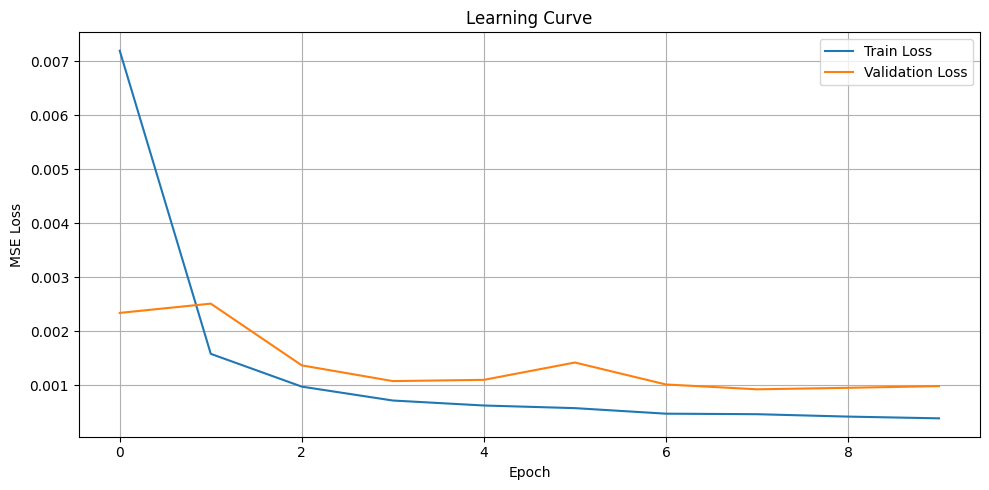

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Learning Curve')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()